#  Gene Sets and Expression for Tumor vs. Normal and Tissue Classification

Use gene sets from [MSigDB](http://software.broadinstitute.org/gsea/msigdb) to both prune the number of genes/features as well as a source of pathway information to encorporate into layer design.

In [54]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as pyplot

# fix random seed for reproducibility
np.random.seed(42)

## Load Expression and Convert To Hugo

Expression in TPM is only available with Ensembl gene identifiers from Xena. Load this up and convert into Hugo gene names.

In [2]:
%%time
expression = pd.read_hdf("data/TcgaTargetGtex_rsem_gene_tpm.hd5", "expression").sort_index(axis=1)
print("expression: samples={} genes={}".format(*expression.shape))

expression: samples=60498 genes=19260
CPU times: user 2.58 s, sys: 3.98 s, total: 6.56 s
Wall time: 6.64 s


In [3]:
"""
Feature labels are ensemble ids, convert to hugo gene names for use in interpreting
hidden layers in any trained models as they are better known to most bioinformaticians 
and clinicians. We're using an assembled table from John Vivian @ UCSC here. Another
option would be ftp://ftp.ebi.ac.uk/pub/databases/genenames/new/tsv/hgnc_complete_set.txt
"""
ensemble_to_hugo = pd.read_table(
    "https://github.com/jvivian/docker_tools/blob/master/gencode_hugo_mapping/attrs.tsv?raw=true",
    index_col=0)
ensemble_to_hugo.head()

,geneName,geneType,geneStatus,transcriptId,transcriptName,transcriptType,transcriptStatus,havanaGeneId,havanaTranscriptId,ccdsId,level,transcriptClass
geneId,,,,,,,,,,,,
ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene,KNOWN,ENST00000456328.2,DDX11L1-002,processed_transcript,KNOWN,OTTHUMG00000000961.2,OTTHUMT00000362751.1,NaN,2,pseudo
ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene,KNOWN,ENST00000450305.2,DDX11L1-001,transcribed_unprocessed_pseudogene,KNOWN,OTTHUMG00000000961.2,OTTHUMT00000002844.2,NaN,2,pseudo
ENSG00000227232.5,WASH7P,unprocessed_pseudogene,KNOWN,ENST00000488147.1,WASH7P-001,unprocessed_pseudogene,KNOWN,OTTHUMG00000000958.1,OTTHUMT00000002839.1,NaN,2,pseudo
ENSG00000278267.1,MIR6859-1,miRNA,KNOWN,ENST00000619216.1,MIR6859-1-201,miRNA,KNOWN,NaN,NaN,NaN,3,nonCoding
ENSG00000243485.3,RP11-34P13.3,lincRNA,KNOWN,ENST00000473358.1,RP11-34P13.3-001,lincRNA,KNOWN,OTTHUMG00000000959.2,OTTHUMT00000002840.1,NaN,2,nonCoding


In [4]:
hugo = ensemble_to_hugo[~ensemble_to_hugo.index.duplicated(keep='first')].reindex(expression.index.values)["geneName"].fillna("")
# Make sure we end up with the order of features being identical as some ensemble id's
# map to the same hugo gene id
assert(expression.index.equals(hugo.index))
# # Change index from Ensembl to Hugo
expression_hugo = expression
expression_hugo.index = hugo.values

In [9]:
expression_hugo.head()

,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2226-SM-5N9CH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-3026-SM-5GZYU,...,TCGA-ZR-A9CJ-01,TCGA-ZS-A9CD-01,TCGA-ZS-A9CE-01,TCGA-ZS-A9CF-01,TCGA-ZS-A9CF-02,TCGA-ZS-A9CG-01,TCGA-ZT-A8OM-01,TCGA-ZU-A8S4-01,TCGA-ZU-A8S4-11,TCGA-ZX-AA5X-01
RP11-368I23.2,-9.9658,-9.9658,-9.9658,-1.2481,-3.8160,-1.7809,-9.9658,-9.9658,-3.6259,-9.9658,...,-9.9658,-4.6082,-9.9658,-9.9658,-4.6082,-9.9658,-3.6259,-9.9658,-9.9658,-9.9658
RP11-167B3.1,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658
RP11-742D12.2,-4.2934,0.0014,-9.9658,-5.5735,0.3573,-9.9658,-6.5064,-5.0116,-9.9658,-5.0116,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-6.5064
RAB4B,5.1190,4.1277,4.4067,5.6860,4.0357,4.6849,4.5009,5.3954,4.9402,5.4683,...,4.1780,4.5547,3.6737,4.9331,3.6254,3.7646,5.5201,5.4216,3.3647,4.7991
AC104071.1,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658


In [10]:
# %%time
# exp = expression_hugo
# exp.apply(np.exp2)
# exp.apply(lambda x: x - 0.001)
# exp.groupby(level=0).aggregate(np.mean).add(0.001).apply(np.log2)

CPU times: user 1min 41s, sys: 26.1 s, total: 2min 7s
Wall time: 1min 33s


In [13]:
%%time
# Multiple Ensemble genes map to the same Hugo name. Each of these values has been normalized via log2(TPM+0.001)
# so we convert back into TPM, compute the mean, and re-normalize
expression_hugo_mean = expression_hugo.apply(np.exp2).apply(lambda x: x - 0.001).groupby(level=0).aggregate(np.mean).add(0.001).apply(np.log2)

CPU times: user 3min, sys: 35 s, total: 3min 35s
Wall time: 2min 41s


In [14]:
expression_hugo_mean.head()

,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2226-SM-5N9CH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-3026-SM-5GZYU,...,TCGA-ZR-A9CJ-01,TCGA-ZS-A9CD-01,TCGA-ZS-A9CE-01,TCGA-ZS-A9CF-01,TCGA-ZS-A9CF-02,TCGA-ZS-A9CG-01,TCGA-ZT-A8OM-01,TCGA-ZU-A8S4-01,TCGA-ZU-A8S4-11,TCGA-ZX-AA5X-01
,-9.9658,-9.9658,-9.9658,-9.9658,-9.965800,-9.9658,-9.9658,-9.965800,-9.965800,-9.96580,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658
5S_rRNA,-9.9658,-9.9658,-9.9658,-9.9658,-9.965800,-9.9658,-9.9658,-9.965800,-9.965800,-9.96580,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658
5_8S_rRNA,-9.9658,-9.9658,-9.9658,-9.9658,-9.965800,-9.9658,-9.9658,-9.965800,-9.965800,-9.96580,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658
7SK,-9.9658,-9.9658,-9.9658,-9.9658,-3.406064,-9.9658,-9.9658,-2.003874,-2.244654,-3.45799,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658
A1BG,4.4595,1.1512,5.2411,5.4758,4.553400,4.6224,4.5028,5.613000,4.447600,4.73020,...,3.6463,11.1518,11.8930,8.9466,7.6347,9.1454,7.6426,3.5994,10.9593,3.5935


In [15]:
# Drop one column that has empty gene name, artificat of Ensembl to Hugo and this will
# ensure the Treehouse compendium used below as a verification matches index wise
X = expression_hugo_mean.drop(labels="").T
X.head()

,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,snoU2-30,snoU2_19,snoU83B,snoZ196,snoZ278,snoZ40,snoZ6,snosnR66,uc_338,yR211F11.2
GTEX-1117F-0226-SM-5GZZ7,-9.9658,-9.9658,-9.965800,4.4595,0.9343,-5.0116,7.5126,0.8164,-2.1140,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,0.158328,-9.9658
GTEX-1117F-0426-SM-5EGHI,-9.9658,-9.9658,-9.965800,1.1512,-1.2828,-6.5064,6.0777,-2.3147,0.5568,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-2.126224,-9.9658
GTEX-1117F-0526-SM-5EGHJ,-9.9658,-9.9658,-9.965800,5.2411,0.8488,-6.5064,10.0319,0.1257,-1.1172,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-0.864951,-9.9658
GTEX-1117F-0626-SM-5N9CS,-9.9658,-9.9658,-9.965800,5.4758,2.6325,-9.9658,9.7572,1.7702,-1.8836,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-0.918501,-9.9658
GTEX-1117F-0726-SM-5GIEN,-9.9658,-9.9658,-3.406064,4.5534,1.3051,-9.9658,7.7931,-0.0725,-2.2447,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-2.018394,-9.9658


In [16]:
%%time
# Load samples and labels
# X = pd.read_hdf("data/TcgaTargetGtex_rsem_gene_tpm.hd5", "expression")
# print("X: samples={} genes={}".format(*X.shape))

Y = pd.read_table("data/TcgaTargetGTEX_phenotype.txt.gz", compression="gzip", header=0,
                      names=["id", "category", "disease", "primary_site", "sample_type", "gender", "study"],
                      sep="\t", encoding="ISO-8859-1", index_col=0, dtype="str")
print("Y: samples={} labels={}".format(*Y.shape))

Y: samples=19131 labels=6
CPU times: user 54.1 ms, sys: 6.91 ms, total: 61 ms
Wall time: 60.4 ms


## Ingest Clinical and Pathways

Load the expression and clinical as wrangled in ingest.ipynb as well as gene sets downloaded from msigdb. Wrangle so that only genes present in each are present and ensure the order of features is consistent.

In [17]:
# Sort so indexes match
X.sort_index(axis=0, inplace=True)
X.sort_index(axis=1, inplace=True)
Y.sort_index(axis=0, inplace=True)

# Remove rows where the class is null or the sample is missing
intersection = X.index.intersection(Y[pd.notnull(Y["primary_site"])].index)
X = X[X.index.isin(intersection)]
Y = Y[Y.index.isin(intersection)]

# Make sure the label and example samples are in the same order
assert(X.index.equals(Y.index))

print(intersection.shape[0], "samples with non-null labels")

19126 samples with non-null labels


In [18]:
# Compute and add a tumor/normal column - TCGA and TARGET have some normal samples, GTEX is all normal.
Y.loc[:, "tumor_normal"] = Y.apply(
    lambda row: "Normal" if row["sample_type"] in ["Cell Line", "Normal Tissue", "Solid Tissue Normal"]
    else "Tumor", axis=1)

# Convert tumor_normal and primary_site into numerical values for two-hot multi-class training
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
Y["tumor_normal_value"] = pd.Series(encoder.fit_transform(Y["tumor_normal"]), index=Y.index)
encoder = LabelEncoder()
Y["primary_site_value"] = pd.Series(encoder.fit_transform(Y["primary_site"]), index=Y.index)
Y.describe(include="all", percentiles=[])

,category,disease,primary_site,sample_type,gender,study,tumor_normal,tumor_normal_value,primary_site_value
count,19126,19126,19126,19126,18968,19126,19126,19126.000000,19126.000000
unique,93,93,46,16,2,3,2,NaN,NaN
top,Breast Invasive Carcinoma,Breast Invasive Carcinoma,Brain,Primary Tumor,Male,TCGA,Tumor,NaN,NaN
freq,1212,1212,1846,9185,10453,10534,10530,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.550559,20.651992
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.497450,12.419634
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,19.000000
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,45.000000


In [19]:
X[0:20000:3000].head()

,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,snoU2-30,snoU2_19,snoU83B,snoZ196,snoZ278,snoZ40,snoZ6,snosnR66,uc_338,yR211F11.2
GTEX-1117F-0226-SM-5GZZ7,-9.9658,-9.9658,-9.965800,4.4595,0.9343,-5.0116,7.5126,0.8164,-2.1140,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,0.158328,-9.9658
GTEX-145LS-1226-SM-5Q5D9,-9.9658,-9.9658,-4.341285,3.3350,1.6281,-6.5064,11.3547,1.0847,-4.6082,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-0.727251,-9.9658
GTEX-X638-0126-SM-47JZ8,-9.9658,-9.9658,-9.965800,4.2609,1.6875,-4.0350,6.7694,0.7146,5.0845,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-2.740712,-9.9658
TCGA-24-1422-01,-9.9658,-9.9658,-4.442188,4.1962,2.3788,-5.5735,6.4925,0.6425,-0.6643,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-3.577273,-4.0350
TCGA-BF-AAP0-06,-9.9658,-9.9658,-9.965800,6.6121,3.7919,-9.9658,7.9917,0.1648,-4.6082,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-3.873583,-9.9658


In [20]:
Y[0:20000:3000].head()

,category,disease,primary_site,sample_type,gender,study,tumor_normal,tumor_normal_value,primary_site_value
id,,,,,,,,,
GTEX-1117F-0226-SM-5GZZ7,Adipose - Subcutaneous,Adipose - Subcutaneous,Adipose Tissue,Normal Tissue,Female,GTEX,Normal,0,0
GTEX-145LS-1226-SM-5Q5D9,Lung,Lung,Lung,Normal Tissue,Female,GTEX,Normal,0,22
GTEX-X638-0126-SM-47JZ8,Skin - Sun Exposed (Lower Leg),Skin - Sun Exposed (Lower Leg),Skin,Normal Tissue,Female,GTEX,Normal,0,33
TCGA-24-1422-01,Ovarian Serous Cystadenocarcinoma,Ovarian Serous Cystadenocarcinoma,Ovary,Primary Tumor,Female,TCGA,Tumor,1,26
TCGA-BF-AAP0-06,Skin Cutaneous Melanoma,Skin Cutaneous Melanoma,Skin,Metastatic,Female,TCGA,Tumor,1,33


In [21]:
# Load gene sets from downloaded MSigDB gmt file (KEGG to for now as its experimental vs. computational)
with open("data/c2.cp.kegg.v6.1.symbols.gmt") as f:
    gene_sets = { line.strip().split("\t")[0]: line.strip().split("\t")[2:] for line in f.readlines()}
print("Loaded {} gene sets".format(len(gene_sets)))

# Drop any genes that are not in X - sort so that the order is the same as X_pruned.columns
gene_sets = {name: sorted([gene for gene in genes if gene in X.columns.values]) 
             for name, genes in gene_sets.items()}

# Find the union of all gene's in the gene sets in order to filter our input rows
all_gene_set_genes = sorted(list(set().union(*[gene_set for gene_set in gene_sets.values()])))
print("Subsetting to {} genes".format(len(all_gene_set_genes)))

# Prune X to only include genes in the gene sets
X_pruned = X.drop(labels=(set(X.columns) - set(all_gene_set_genes)), axis=1, errors="ignore")
assert X_pruned["TP53"]["TCGA-ZP-A9D4-01"] == X["TP53"]["TCGA-ZP-A9D4-01"]
print("X_pruned shape", X_pruned.shape)

Loaded 186 gene sets
Subsetting to 5172 genes
X_pruned shape (19126, 5172)


In [22]:
# Make sure the genes are the same and in the same order
assert len(all_gene_set_genes) == len(X_pruned.columns.values)
assert list(X_pruned.columns.values) == all_gene_set_genes

## Wrangle Labels, Train and Test Sets

Add one hot labels for tumor/normal and primary site and then build training and test sets stratifying on primary site.

In [23]:
# Create a multi-label output with tumor/normal + primary site one-hots
from keras.utils import np_utils
primary_site_one_hot = np_utils.to_categorical(Y["primary_site_value"])
tumor_normal_one_hot = Y["tumor_normal_value"]
Y_multiclass_onehot = np.append(
    tumor_normal_one_hot.values.reshape(tumor_normal_one_hot.shape[0],-1), 
    primary_site_one_hot, axis=1)
print(Y_multiclass_onehot.shape)
print(Y_multiclass_onehot[0:20000:5000])

(19126, 47)
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [24]:
# Split into stratified training and test sets based on classes (i.e. tissue type) so that we have equal
# proportions of each tissue type in the train and test sets
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X_pruned.values, Y["tumor_normal_value"]):
    X_train, X_test = X_pruned.values[train_index], X_pruned.values[test_index]
    y_train, y_test = Y_multiclass_onehot[train_index], Y_multiclass_onehot[test_index]
    classes_train, classes_test = Y["primary_site_value"].values[train_index], Y["primary_site_value"].values[test_index]

print(X_train.shape, X_test.shape)

(15300, 5172) (3826, 5172)


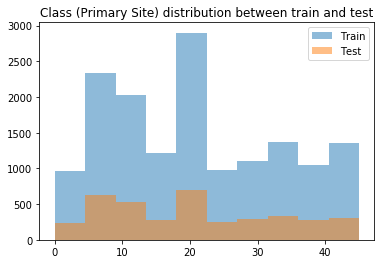

In [25]:
pyplot.hist(classes_train, alpha=0.5, label='Train')
pyplot.hist(classes_test, alpha=0.5, label='Test')
pyplot.legend(loc='upper right')
pyplot.title("Class (Primary Site) distribution between train and test")
pyplot.show()

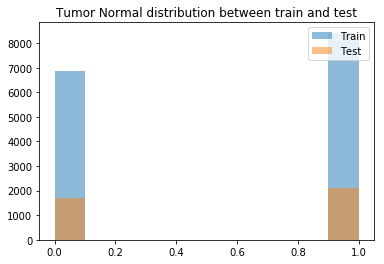

In [26]:
pyplot.hist(y_train[:, 0], alpha=0.5, label='Train')
pyplot.hist(y_test[:, 0], alpha=0.5, label='Test')
pyplot.legend(loc='upper right')
pyplot.title("Tumor Normal distribution between train and test")
pyplot.show()

## Tumor Normal Binary Classification
First train a basic binary tumor vs. normal classifier.

In [27]:
from keras.models import Model, Sequential
from keras.layers import InputLayer, Dense, BatchNormalization, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

epochs=10
batch_size=128

classify = [
    InputLayer(input_shape=(X_train.shape[1],)),
    BatchNormalization(),

    Dense(32, activation='relu'),
    Dropout(0.5),

    Dense(8, activity_regularizer=regularizers.l1(1e-5), activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
]

model = Sequential(classify)
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks=[EarlyStopping(monitor='acc', min_delta=0.05, patience=2, verbose=2, mode="max")]
model.fit(X_train, y_train[:,0], epochs=epochs, batch_size=batch_size, shuffle="batch", callbacks=callbacks)

print(model.metrics_names, model.evaluate(X_test, y_test[:,0]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5172)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5172)              20688     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                165536    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total para

## Multi-label Tumor vs. Normal and Primary Site Classification
Multi-label classification of tumor/normal + primary site with union of genes from all gene sets as input

In [56]:
%%time
from keras.models import Model, Sequential
from keras.layers import InputLayer, Dense, BatchNormalization, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

epochs=10
batch_size=128

classify = [
    InputLayer(input_shape=(X_train.shape[1],)),
    BatchNormalization(),

    Dense(32, activation='relu'),
    Dropout(0.5),

    Dense(16, activity_regularizer=regularizers.l1(1e-5), activation='relu'),
    Dropout(0.5),
    
    Dense(y_train.shape[1], activation='sigmoid')
]

model = Sequential(classify)
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks=[EarlyStopping(monitor='acc', min_delta=0.05, patience=2, verbose=2, mode="max")]
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle="batch", callbacks=callbacks)

print(model.metrics_names, model.evaluate(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 5172)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 5172)              20688     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                165536    
_________________________________________________________________
dropout_193 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_194 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 47)                799       
Total para

In [69]:
ids = ["GTEX-1117F-0226-SM-5GZZ7"]

for id in ids:
    print(id, Y.loc[id].tumor_normal, Y.loc[id].primary_site)
    prediction = model.predict(np.array([X_pruned.loc[id].values]))
    print(np.argmax(prediction[0][1:]))
    print("Tumor" if prediction[0][0] >= 0.5 else "Normal")

GTEX-1117F-0226-SM-5GZZ7 Normal Adipose Tissue
33
Normal


In [72]:
encoder.inverse_transform([33])

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['Skin'], dtype=object)

## Mulit-label Classification w/Per Pathway Sub-Network Input Layer
For each pathway build a custom input layer that extracts the expression levels for the genes in the pathway from the full input vector and feeds this into a dense single output hidden neuron. These are then aggregated and fed into a standard set of stacked layers and trained to classify tumor/norml and primary site. The hidden per pathway neurons are named after the pathway an 'may' indicate which pathway lead to a given classification.

In [29]:
# Convert list of gene names into list of indexes into the features of X_pruned
gene_set_indexes = {name: np.searchsorted(X_pruned.columns.values, genes) for name, genes in gene_sets.items()}
print("Pathway KEGG_ABC_TRANSPORTERS Gene Indexes:", gene_set_indexes["KEGG_ABC_TRANSPORTERS"])

Pathway KEGG_ABC_TRANSPORTERS Gene Indexes: [  11   12   13   14   15   16   17   18   19   20   21   22   23   24
   25   26   27   28   29   30   31   32   33   34   35   36   37   38
   39   40   41   42   43   44   45   46   47   48   49   50   51  848
 4692 4693]


In [30]:
%%time
from keras.models import Model, Sequential
from keras.layers import Input, Lambda, Dense, BatchNormalization, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers.merge import concatenate
from keras import backend as K
import itertools

main_input = Input(shape=(X_train.shape[1],), name="main_input")

"""
Build per pathway sub-networks
"""
# Set to a small number (~4) for debugging, set to None to build all pathways
# max_num_pathways = 4
max_num_pathways = None 

# Extract the features/gene's for each pathway from the aggregate x input vector
pathways = [Lambda(lambda x: K.concatenate([x[:, i:i+1] for i in indexes]))(main_input)
            for name, indexes in itertools.islice(gene_set_indexes.items(), max_num_pathways)]

# Add a dense hidden layer per pathway with width proportional to the number of genes in the pathway
# pathways = [Dense(max(2, len(i)//4), activation='relu')(p) for p, i in zip(pathways, gene_set_indexes.values())]

# Add a named binary output for each pathway 
# pathways = [Dense(1, activity_regularizer=regularizers.l1(1e-5), activation='relu', name=name)(p) 
#             for p, name in zip(pathways, gene_set_indexes.keys())]

pathways = [Dropout(0.5)(Dense(1, activity_regularizer=regularizers.l1(1e-5), activation='relu', name=name)(p))
            for p, name in zip(pathways, gene_set_indexes.keys())]

# Concatenate the binary outputs of each of the sub-networks back into a single vector
x = keras.layers.concatenate(pathways)
           
"""
Add traditional stacked network for final multi-label classification
"""
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
    
x = Dense(8, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(y_train.shape[1], activation='sigmoid')(x)

model = Model(inputs=[main_input], outputs=[x])
# print(model.summary())  # Too detailed when building full set of pathways
print("Trainable params::", np.sum([np.product(v.shape) for v in model.trainable_weights]).value)

Trainable params:: 16352
CPU times: user 1min 33s, sys: 2.49 s, total: 1min 36s
Wall time: 1min 36s


In [31]:
%%time
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="data/logs/{}".format(time()))

epochs=10
batch_size=128

print("Compiling and training...")
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle="batch", 
          callbacks=[EarlyStopping(monitor='acc', min_delta=0.05, patience=2, verbose=2, mode="max"), tensorboard])
print(model.metrics_names, model.evaluate(X_test, y_test))

Compiling and training...
Epoch 1/10
15300/15300 [==============================] - 41s 3ms/step - loss: 1.0195 - acc: 0.7457
Epoch 2/10
15300/15300 [==============================] - 15s 1ms/step - loss: 0.5894 - acc: 0.8278
Epoch 3/10
15300/15300 [==============================] - 15s 1ms/step - loss: 0.3725 - acc: 0.9041
Epoch 4/10
15300/15300 [==============================] - 15s 995us/step - loss: 0.2456 - acc: 0.9526
Epoch 5/10
15300/15300 [==============================] - 15s 980us/step - loss: 0.2025 - acc: 0.9641
Epoch 6/10
15300/15300 [==============================] - 15s 1ms/step - loss: 0.1787 - acc: 0.9673
Epoch 7/10
15300/15300 [==============================] - 15s 1ms/step - loss: 0.1656 - acc: 0.9683
Epoch 00007: early stopping
3826/3826 [==============================] - 31s 8ms/step
['loss', 'acc'] [0.11060874701184997, 0.9691584472000693]
CPU times: user 7min 58s, sys: 2min 48s, total: 10min 47s
Wall time: 4min 4s


## Treehouse
Evaluate the model on samples from the [Treehouse public compendium](https://treehousegenomics.soe.ucsc.edu/explore-our-data/)

In [32]:
%%time
if not os.path.exists("data"):
    os.makedirs("data")
    
if not os.path.exists("data/treehouse_public_samples_unique_hugo_log2_tpm_plus_1.2017-09-11.tsv.gz"):
    print("Downloading Treehouse Public Compendium")
    r = requests.get("https://treehouse.xenahubs.net/download/treehouse_public_samples_unique_hugo_log2_tpm_plus_1.2017-09-11.tsv.gz")
    r.raise_for_status()
    with open("data/treehouse_public_samples_unique_hugo_log2_tpm_plus_1.2017-09-11.tsv.gz", "wb") as f:
        for chunk in r.iter_content(32768):
            f.write(chunk)

if not os.path.exists("data/treehouse_public_samples_unique_hugo_log2_tpm_plus_1.2017-09-11.hd5"):
    print("Converting expression to dataframe and storing in hdf5 file")
    expression = pd.read_csv("data/treehouse_public_samples_unique_hugo_log2_tpm_plus_1.2017-09-11.tsv.gz", 
                             sep="\t", index_col=0).dropna().astype(np.float32)
    expression.to_hdf("data/treehouse_public_samples_unique_hugo_log2_tpm_plus_1.2017-09-11.hd5", "expression", mode="w", format="fixed")

treehouse_expression = pd.read_hdf("data/treehouse_public_samples_unique_hugo_log2_tpm_plus_1.2017-09-11.hd5", "expression").sort_index(axis=1)
print("expression: samples={} genes={}".format(*expression.shape))

expression: samples=60498 genes=19260
CPU times: user 973 ms, sys: 2.83 s, total: 3.8 s
Wall time: 3.8 s


In [33]:
# Convert into same normalized TPM: X log2(TPM+0.001)  XTreehouse log2(TPM+1) and invert to match X
XTreehouse = treehouse_expression.T.apply(lambda x: np.log2((np.power(2, x) - 1.0) + 0.001))

# Check that the features/genes are identical and in the same order
assert np.array_equal(X.columns.values, XTreehouse.columns.values)

XTreehouse.head()

Gene,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,snoU2-30,snoU2_19,snoU83B,snoZ196,snoZ278,snoZ40,snoZ6,snosnR66,uc_338,yR211F11.2
TARGET-10-PAKSWW-03,-9.965784,-9.965784,-3.675801,5.631403,3.270715,-9.965784,-0.886033,-2.634004,-2.931300,-9.965784,...,-9.965784,-9.965784,-9.965784,-9.965784,-9.965784,-9.965784,-9.965784,-9.965784,-1.093503,-4.604685
TARGET-10-PAMXHJ-09,-9.965784,-9.965784,-9.965784,5.203204,3.016318,-9.965784,-0.996812,0.537100,-9.965784,-9.965784,...,-9.965784,-9.965784,-9.965784,-9.965784,-9.965784,-9.965784,-9.965784,-9.965784,-1.430414,-9.965784
TARGET-10-PAMXSP-09,-9.965784,-9.965784,-9.965784,5.406404,2.163832,-9.965784,-0.284324,-2.931300,-3.456416,-9.965784,...,-9.965784,-9.965784,-9.965784,-9.965784,-9.965784,-9.965784,-9.965784,-9.965784,-1.112369,-9.965784
TARGET-10-PANCVR-03,-9.965784,-9.965784,-9.965784,6.067202,1.628147,-9.965784,-1.883068,-6.493342,-9.965784,-9.965784,...,-9.965784,-9.965784,-9.965784,-9.965784,-9.965784,-9.965784,-9.965784,-9.965784,-1.724956,-9.965784
TARGET-10-PANCVR-04,-9.965784,-9.965784,-4.365655,5.172804,1.856440,-5.006953,-1.148480,-3.306172,-1.684536,-9.965784,...,-9.965784,-9.965784,-9.965784,-9.965784,-9.965784,-9.965784,-9.965784,-9.965784,-1.367746,-5.006953


In [34]:
# Check to see if the common samples at this point actually d
# X log2(TPM+0.001)  XTreehouse log2(TPM+1)
for sample in ["TARGET-10-PAMXHJ-09", "TARGET-10-PANCVR-04", "TARGET-10-PAMXSP-09"]:
    for gene in ["AAGAB", "TP53", "BRCA1"]:
        print(X.loc[sample][gene], XTreehouse.loc[sample][gene])

3.542399833268772 3.5424123
5.848000021348486 5.848003
2.8819000795903658 2.8819194
3.802300007434838 3.8023105
5.156300072229567 5.1563044
3.2495998806503223 3.249615
2.411700016129224 2.411727
3.9346000910563292 3.9346094
1.438799972912041 1.4388531


In [35]:
# Read in the clinical data for Treehouse
import requests
if not os.path.exists("data/treehouse_public_samples_clinical_metadata.2017-09-11.tsv.gz"):
    with open("data/treehouse_public_samples_clinical_metadata.2017-09-11.tsv.gz", "wb") as f:
        f.write(requests.get("https://treehouse.xenahubs.net/download/treehouse_public_samples_clinical_metadata.2017-09-11.tsv.gz").content)

YTreehouse = pd.read_table("data/treehouse_public_samples_clinical_metadata.2017-09-11.tsv.gz", compression="gzip",
                  header=0, names=["id", "age_in_years", "gender", "disease"],
                  sep="\t", encoding="ISO-8859-1", index_col=0, dtype="str").sort_index(axis=0)

YTreehouse.head()

,age_in_years,gender,disease
id,,,
TARGET-10-PAKSWW-03,15.11,male,acute lymphoblastic leukemia
TARGET-10-PAMXHJ-09,6.08,male,acute lymphoblastic leukemia
TARGET-10-PAMXSP-09,3.35,male,acute lymphoblastic leukemia
TARGET-10-PANCVR-03,6.4,male,acute lymphoblastic leukemia
TARGET-10-PANCVR-04,6.4,male,acute lymphoblastic leukemia


In [36]:
XTreehouse_pruned = XTreehouse.drop(labels=(set(XTreehouse.columns) - set(all_gene_set_genes)), axis=1, errors="ignore")

In [37]:
X_pruned.loc["TARGET-10-PAMXHJ-09"][0:10]

A2M        -0.9971
A4GALT     -4.6082
AACS        0.7916
AADAT      -9.9658
AANAT       1.6695
AARS        3.3421
AARS2       1.0293
AASDH       2.3337
AASDHPPT    2.8681
AASS        2.2633
Name: TARGET-10-PAMXHJ-09, dtype: float64

In [38]:
XTreehouse_pruned.loc["TARGET-10-PAMXHJ-09"][0:10]

Gene
A2M        -0.996812
A4GALT     -4.604685
AACS        0.791683
AADAT      -9.965784
AANAT       1.669545
AARS        3.342114
AARS2       1.029371
AASDH       2.333729
AASDHPPT    2.868120
AASS        2.263330
Name: TARGET-10-PAMXHJ-09, dtype: float32

In [39]:
(XTreehouse_pruned.loc["TARGET-10-PAMXHJ-09"]- X_pruned.loc["TARGET-10-PAMXHJ-09"]).idxmax()

'ABCA13'

In [40]:
print(XTreehouse_pruned.loc["TARGET-10-PAMXHJ-09"]["ABCA13"], X_pruned.loc["TARGET-10-PAMXHJ-09"]["ABCA13"])

-6.493342 -6.506400067567295


In [41]:
treehouse_expression.loc["NDUFA7"]["TARGET-10-PAMXHJ-09"]

2.6307862

In [42]:
expression_hugo.loc["NDUFA7"]["TARGET-10-PAMXHJ-09"]

NDUFA7    5.2235
NDUFA7   -9.9658
Name: TARGET-10-PAMXHJ-09, dtype: float32

In [43]:
np.log2(((2**5.2235 - 0.001) + (2**-9.9658 - 0.001))/2 + 1.0)

4.2986951774244995

In [49]:
print(np.array_equal(XTreehouse_pruned.columns, X_pruned.columns))
np.allclose(XTreehouse_pruned.loc["TARGET-10-PAMXHJ-09"], X_pruned.loc["TARGET-10-PAMXHJ-09"], .1, .1)

True


False

In [51]:
np.argmax(XTreehouse_pruned.loc["TARGET-10-PAMXHJ-09"] - X_pruned.loc["TARGET-10-PAMXHJ-09"])

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


'ABCA13'

In [55]:
model.predict(np.array([X_pruned.loc["GTEX-1117F-0226-SM-5GZZ7"].values]))

array([[0.5525975 , 0.02865992, 0.01252445, 0.01043886, 0.01175033,
        0.02347344, 0.01829199, 0.02749614, 0.00590744, 0.12723434,
        0.08917617, 0.00800527, 0.00504306, 0.04485957, 0.00649813,
        0.05484591, 0.00640453, 0.01233932, 0.02747992, 0.01815994,
        0.0713362 , 0.00754456, 0.03730804, 0.08871661, 0.00329792,
        0.02167659, 0.00817081, 0.02596463, 0.02461934, 0.00284912,
        0.00559646, 0.03551614, 0.00597472, 0.01314476, 0.0851528 ,
        0.01012739, 0.01239774, 0.01220924, 0.0367674 , 0.01529241,
        0.00993054, 0.00325384, 0.01007175, 0.03231018, 0.00514256,
        0.00254307, 0.03689089]], dtype=float32)

In [45]:
predictions = {id: model.predict(np.array([XTreehouse_pruned.loc[id].values])) 
               for id in XTreehouse.index if id.startswith("TH")}

In [53]:
for id, prediction in predictions.items():
    print(id, prediction[0][0])

TH01_0051_S01 0.5544241
TH01_0053_S01 0.5525975
TH01_0054_S01 0.5525975
TH01_0055_S01 0.5552045
TH01_0061_S01 0.55034375
TH01_0062_S01 0.5534985
TH01_0063_S01 0.5525975
TH01_0064_S01 0.5525975
TH01_0069_S01 0.5609254
TH01_0119_S01 0.57087183
TH01_0120_S01 0.5512318
TH01_0121_S01 0.5628921
TH01_0122_S01 0.55185616
TH01_0123_S01 0.5572721
TH01_0124_S01 0.5554888
TH01_0125_S01 0.5503183
TH01_0126_S01 0.5841042
TH01_0127_S01 0.5516281
TH01_0128_S01 0.55380213
TH01_0129_S01 0.56452465
TH01_0130_S01 0.5709104
TH01_0131_S01 0.5500016
TH01_0132_S01 0.55852586
TH01_0133_S01 0.55954057
TH01_0134_S01 0.5607296
TH01_0135_S01 0.5526376
TH03_0003_S01 0.55958474
TH03_0003_S03 0.55382854
TH03_0003_S04 0.55299443
TH03_0004_S02 0.55276316
TH03_0004_S03 0.5554241
TH03_0004_S04 0.55569017
TH03_0005_S01 0.5525975
TH03_0006_S01 0.5586057
TH03_0006_S03 0.55362123
TH03_0008_S01 0.5525975
TH03_0010_S01 0.55542237
TH03_0010_S02 0.5525972
TH03_0011_S01 0.5530937
TH03_0012_S01 0.5525975
TH03_0012_S02 0.5525975
TH

In [46]:
for id, prediction in predictions.items():
    print(id, np.argmax(prediction[0][1:]))

TH01_0051_S01 8
TH01_0053_S01 8
TH01_0054_S01 8
TH01_0055_S01 8
TH01_0061_S01 8
TH01_0062_S01 8
TH01_0063_S01 8
TH01_0064_S01 8
TH01_0069_S01 8
TH01_0119_S01 8
TH01_0120_S01 8
TH01_0121_S01 8
TH01_0122_S01 8
TH01_0123_S01 8
TH01_0124_S01 8
TH01_0125_S01 8
TH01_0126_S01 8
TH01_0127_S01 8
TH01_0128_S01 8
TH01_0129_S01 8
TH01_0130_S01 8
TH01_0131_S01 8
TH01_0132_S01 8
TH01_0133_S01 8
TH01_0134_S01 8
TH01_0135_S01 8
TH03_0003_S01 8
TH03_0003_S03 8
TH03_0003_S04 8
TH03_0004_S02 8
TH03_0004_S03 8
TH03_0004_S04 8
TH03_0005_S01 8
TH03_0006_S01 8
TH03_0006_S03 8
TH03_0008_S01 8
TH03_0010_S01 8
TH03_0010_S02 8
TH03_0011_S01 8
TH03_0012_S01 8
TH03_0012_S02 8
TH03_0013_S01 8
TH03_0013_S02 8
TH03_0014_S01 8
TH03_0015_S01 8
TH03_0016_S01 8
TH03_0017_S01 8
TH03_0018_S01 8
TH03_0018_S02 8
TH03_0019_S01 8
TH03_0020_S01 8
TH03_0022_S01 8
TH03_0024_S01 8
TH03_0025_S02 8
TH03_0027_S01 8
TH03_0029_S01 8
TH03_0038_S01 8
TH03_0103_S01 8
TH03_0104_S01 8
TH03_0105_S01 8
TH03_0106_S01 8
TH03_0107_S01 8
TH03_011

In [47]:
# sample_id = "TH01_0717_S01"

# x = pd.read_csv("/treehouse/archive/downstream/{}/secondary/ucsc_cgl-rnaseq-cgl-pipeline-3.3.4-785eee9/RSEM/Hugo/rsem_genes.hugo.results"
#             .format(sample_id), 
#             sep="\t").set_index("gene_name")
# print(x.shape)
# x.head()

In [48]:
x_pruned = x.loc[X_pruned.columns.values]
x_pruned.sort_index(axis=0, inplace=True)
x_pruned = x_pruned[~x_pruned.index.duplicated(keep='first')]
x_pruned.shape

AttributeError: 'Tensor' object has no attribute 'loc'

In [ ]:
x_pruned["expected_count"].values

In [ ]:
model.predict(np.array([x_pruned["FPKM"].values]))